In [ ]:
! pip install pip install torchvision==0.16.0
! pip install pip install scikit-learn==1.2.2
! pip install torch==2.1.0
! pip install matplotlib==3.7.1
! pip install seaborn==0.13.1
! pip install numba==0.58.1
! pip install numpy==1.23.5

ERROR: Could not find a version that satisfies the requirement torchvision==0.16.0+cu121 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1)
ERROR: No matching distribution found for torchvision==0.16.0+cu121
ERROR: Could not find a version that satisfies the requirement torch==2.1.0+cu121 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1)
ERROR: No matching distribution found for torch==2.1.0+cu121


## Installing and Loading Packages

In [ ]:
from sklearn.metrics import confusion_matrix
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive
import torch.optim as optim
from numba import cuda
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
import numpy as np
import torchvision
import sklearn
import random
import shutil
import torch
import time
import os

In [ ]:
# Check the GPU model
if torch.cuda.is_available():
    print('Number of GPUs:', torch.cuda.device_count())
    print('Model GPU:', torch.cuda.get_device_name(0))
    print('Total GPU Memory [GB]:',torch.cuda.get_device_properties(0).total_memory / 1e9)

Number of GPUs: 1
Model GPU: Tesla T4
Total GPU Memory [GB]: 15.835660288


In [ ]:
# Reset GPU memory
device = cuda.get_current_device()
device.reset()

## Preparing the images

In [ ]:
# Delete the folders (if they exist)
try:
    shutil.rmtree('EuroSAT_RGB')
    shutil.rmtree('__MACOSX')
    shutil.rmtree('training_images')
    shutil.rmtree('test_images')
except Exception as e:
    print(f"The folders do not exist or have already been deleted!")

The folders do not exist or have already been deleted!


In [ ]:
# If the image dataset is on your drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset from your driver or temporary file
!unzip /content/EuroSAT_RGB.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2494.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2494.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2480.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2480.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_292.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_292.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_1189.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_1189.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_1837.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_1837.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2496.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2496.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_284.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCro

In [ ]:
# Create folders
os.mkdir('training_images')
os.mkdir('test_images')

In [ ]:
# Set the source of the images
source_images = 'EuroSAT_RGB'

In [ ]:
# Set training and testing destination
training_destination = 'training_images'
test_destination = 'test_images'

## Automating Image Separation

In [ ]:
# Class variable and dictionary
image_class = 0
class_dict = {}

In [ ]:
# Create the variable to manipulate the images
files = os.listdir(source_images)
files.sort()

In [ ]:
# Iterate over all files (or directories) in the 'files' list
for path_file in files:

   
    if path_file[0] != '.':
        
        images = os.listdir(source_images + '/' + path_file)
        
        sample_size = int(len(images) * 0.8)
        
        train = []
        
        final_dest = training_destination + '/' + str(image_class)
        
        os.mkdir(final_dest)
        
        for file_name in random.sample(images, sample_size):
            
            shutil.copy2(os.path.join(source_images, path_file, file_name), final_dest)
            
            train.append(file_name)
        
        test_images = list(set(images) - set(train))
      
        final_dest = test_destination + '/' + str(image_class)
        
        os.mkdir(final_dest)
       
        for test_image in test_images:
            shutil.copy2(os.path.join(source_images, path_file, test_image), final_dest)
       
        class_dict[image_class] = path_file
       
        image_class += 1

## Pre-Processing and Creation of Dataloaders

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:

training_dataset = torchvision.datasets.ImageFolder(root = 'training_images', transform = transform)

In [ ]:
dl_training = torch.utils.data.DataLoader(training_dataset, batch_size = 64, shuffle = True, num_workers = 2)

In [ ]:
test_dataset = torchvision.datasets.ImageFolder(root = 'test_images', transform = transform)

In [ ]:
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 2)

## Viewing Images

In [ ]:
def imshow(img):
  
    img = img / 2 + 0.5
 
    npimg = img.numpy()
 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# Get a batch of images
dataiter = iter(dl_training)
images, labels = next(dataiter)

In [ ]:
mapping = {0:'AnnualCrop',
              1:'Forest',
              2:'HerbaceousVegetation',
              3:'Highway',
              4:'Industrial',
              5:'Pasture',
              6:'PermanentCrop',
              7:'Residential',
              8:'River',
              9:'SeaLake'}

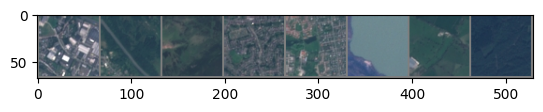

In [ ]:
# Show the image
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(8)))

## Modeling - Building the Deep Learning Model

In [ ]:

class SATNet(nn.Module):
    
    def __init__(self):
       
        super(SATNet, self).__init__()        
      
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
       
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
       
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
       
        self.dropout1 = nn.Dropout(0.25)
       
        self.dropout2 = nn.Dropout(0.5)
       
        self.fc1 = nn.Linear(215296, 2048)
       
        self.fc2 = nn.Linear(2048, 512)
        
        self.fc3 = nn.Linear(512, 128)
        
        self.fc4 = nn.Linear(128, 10)
   
    def forward(self, x):
       
        x = self.conv1(x)
    
        x = F.relu(x)
       
        x = self.conv2(x)
        
        x = F.relu(x)
        
        x = self.conv3(x)
       
        x = F.relu(x)
        
        x = F.max_pool2d(x, 2)
       
        x = self.dropout1(x)
      
        x = torch.flatten(x, 1)
      
        x = self.fc1(x)
        
        x = F.relu(x)
      
        x = self.dropout2(x)
       
        x = self.fc2(x)
        
        x = F.relu(x)
      
        x = self.fc3(x)
       
        x = F.relu(x)
      
        x = self.fc4(x)
       
        return F.log_softmax(x, dim = 1)

In [ ]:
# Create the model
model = SATNet()

Labels: 4 3 2 7 7 9 5 1


In [ ]:
print(model)

SATNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model.to(device)

SATNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

## Selecting the Error Function

In [ ]:
criterion = nn.CrossEntropyLoss()

## Selecting the Optimizer

In [ ]:
optimizer = optim.Adam(model.parameters())

## Model Training

In [ ]:
num_epochs = 30

In [ ]:
testiter = iter(dl_test)

In [ ]:
%%time
print('Training Started!')

for epoch in range(num_epochs):
    
    running_loss = 0.0

    i = 0
  
    for data in (pbar := tqdm(dl_training)):
       
        pbar.set_description(f"\nEpoch {epoch}")
       
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
       
        optimizer.zero_grad()
       
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
       
        loss.backward()
        
        optimizer.step()
       
        running_loss += loss.item()
        
        total_correct = 0
        total_samples = 0
        
        if i % 100 == 0:
           
            with torch.no_grad():
               
                test_images, test_labels = next(testiter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)
                
                test_outputs = model(test_images[:8])
                
                _, predicted = torch.max(test_outputs, 1)
       
        i += 1
    
    print(f"Epoch {epoch}, Loss: {running_loss / (i)}")

print('Training Completed!')

Training Started!


Epoch 0: 100%|██████████| 338/338 [01:34<00:00,  3.56it/s]


Epoch 0, Loss: 1.2121833513474323


Epoch 1: 100%|██████████| 338/338 [01:36<00:00,  3.52it/s]


Epoch 1, Loss: 0.6855705147664223


Epoch 2: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 2, Loss: 0.47790620110091375


Epoch 3: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 3, Loss: 0.29852506752021213


Epoch 4: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 4, Loss: 0.20792910659454278


Epoch 5: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 5, Loss: 0.1563519555634472


Epoch 6: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 6, Loss: 0.09915109789109178


Epoch 7: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 7, Loss: 0.08555791019282949


Epoch 8: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 8, Loss: 0.08959772611538377


Epoch 9: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 9, Loss: 0.06755715164341468


Epoch 10: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 10, Loss: 0.06297847149465179


Epoch 11: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 11, Loss: 0.05691830994250988


Epoch 12: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 12, Loss: 0.04383524555004114


Epoch 13: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 13, Loss: 0.06319785756096878


Epoch 14: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 14, Loss: 0.04802527344756699


Epoch 15: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 15, Loss: 0.03621577072324446


Epoch 16: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 16, Loss: 0.04168534233788829


Epoch 17: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 17, Loss: 0.040473852296271665


Epoch 18: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 18, Loss: 0.03856640352654259


Epoch 19: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 19, Loss: 0.04840722431828865


Epoch 20: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 20, Loss: 0.03967661519283284


Epoch 21: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 21, Loss: 0.037239626403116156


Epoch 22: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 22, Loss: 0.057191005983639964


Epoch 23: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 23, Loss: 0.04561983626179146


Epoch 24: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 24, Loss: 0.029684958109278584


Epoch 25: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 25, Loss: 0.03562312879759874


Epoch 26: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 26, Loss: 0.029716567973663635


Epoch 27: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


Epoch 27, Loss: 0.023822105247691825


Epoch 28: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


Epoch 28, Loss: 0.028708507174701078


Epoch 29: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]

Epoch 29, Loss: 0.0353946696635852
Training Completed!
CPU times: user 40min 57s, sys: 38.9 s, total: 41min 36s
Wall time: 48min 11s


## Model Evaluation

In [ ]:
total_correct = 0
total_samples = 0

In [ ]:
model.eval()

with torch.no_grad():
  
    for data in (pbar := tqdm(dl_test)):
        
        pbar.set_description(f"Evaluating the Model.")
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total_samples += labels.size(0)
        
        total_correct +=  (predicted == labels).sum().item()

Evaluating the Model.: 100%|██████████| 5400/5400 [01:09<00:00, 77.38it/s]


In [ ]:
accuracy = total_correct/total_samples
print(accuracy)

0.847037037037037


## Deploy and Use of the Model

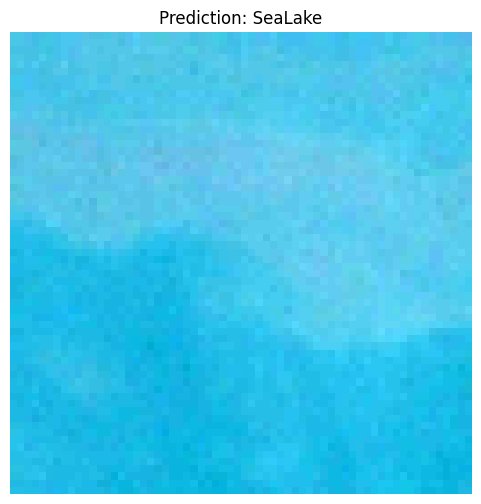

In [ ]:
with torch.no_grad():

    
    data_iter = iter(dl_test)
    data = next(data_iter)
 
    inputs, _ = data
   
    image = inputs[0].unsqueeze(0)
   
    image = image.to(device)
    
    outputs = model(image)
   
    _, predicted = torch.max(outputs, 1)
   
    image_numpy = image.cpu().numpy()[0]
    
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    
    if image_numpy.shape[2] == 1: 
        image_numpy = np.squeeze(image_numpy, axis=2)
    elif image_numpy.shape[2] == 3:  
        image_numpy = (image_numpy - image_numpy.min()) / (image_numpy.max() - image_numpy.min()) 

    plt.figure(figsize=(6, 6))
    plt.imshow(image_numpy)
    plt.title(f'Prediction: {mapping[predicted.item()]}')
    plt.axis('off')
    plt.show()